In [3]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd

# Read dataset off Github
hs_2017 = pd.read_csv("https://github.com/jeffweltman/MSDS7331/raw/master/hs_2017.csv",index_col=0)
hs_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 469
Columns: 395 entries, student_num to nc_district
dtypes: float64(323), int64(72)
memory usage: 1.3 MB


Let's remove the columns that are largely lacking data (mostly one-hot encoded variables) and see if that affects our clustering performance.

In [4]:
# Preparing the Classification variables
Y_class = hs_2017['sat_high_level']
X_class = hs_2017.drop(columns=['nc_district', 'sat_high_level', 'sat_avg_score_num'])

from sklearn.preprocessing import StandardScaler

# Standardize the data to a more normally distributed data
scaler_class = StandardScaler()
scaler_class.fit(X_class)

StandardScaler(copy=True, with_mean=True, with_std=True)

As our previous work demonstrated, the most accurate classifier we've configured for use with this data set is the Random Forest classifier. We'll therefore instantiate that as the model upon which we'll cluster.

In [7]:
#Divide data into test and training splits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, recall_score, f1_score


# Generate a 90/10 training/test split of data
X_train, X_test, y_train, y_test = train_test_split(X_class, Y_class, test_size=0.1, random_state=0)

# Generate & train instance of RandomForest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# EvaluateClassifierEstimator(rf, X_class, Y_class, cv_class)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

First we run the KMeans with the default 8 clusters.

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

cv_class = StratifiedShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

# X1 = df_imputed[['Pclass','Fare']]
clf = rf

cls = KMeans(n_clusters=8, init='k-means++',n_init=10,random_state=1)
cls.fit(X_class)
newfeature = cls.labels_ # the labels from kmeans clustering

# y = df_imputed['Survived']
# X = df_imputed[['Age','IsMale','Parch','SibSp']]
X = np.column_stack((X_class,pd.get_dummies(newfeature)))

acc = cross_val_score(clf,X,y=Y_class,cv=cv_class)

print ("Average accuracy (with kmeans)= ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy (with kmeans)=  86.51162790697674 +- 4.855956515772347


Let's see if we can improve upon accuracy and/or standard deviation.  

By utilizing the 'Elbow method', we attempt to identify the optimal number of clusters as identified by the inflection point, or 'elbow', achieved at the point where the SSE reaches an observably low point.  
  
What we see instead is a smooth curve which indicates that the data may not be very clustered.  
(See Robert Gove's Block: https://bl.ocks.org/rpgove/0060ff3b656618e9136b) 

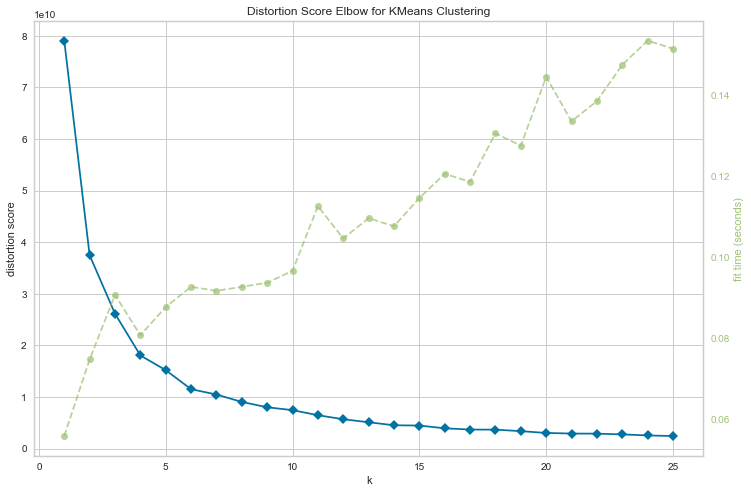

In [10]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from matplotlib import pyplot
import seaborn as sns

newdims = (12, 8)
fig, ax = pyplot.subplots(figsize=newdims)

# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(KMeans(), k=(1,26)) #curve continues smoothly beyond 25 clusters

visualizer.fit(X_class) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

We'll turn then to silhouette scores.
We'll run a *for each* loop to compute the silhouette coefficient - as well as the mean accuracy and standard deviation - for KMeans with 2-200 clusters.  
We'll output the results to a dataframe for analysis.

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from sklearn.metrics import pairwise_distances

cv_class = StratifiedShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

clf = rf

cluster_performance = []

for i in range(2,201):
    cls = KMeans(n_clusters=i, init='k-means++',n_init=10,random_state=1)
    cls.fit(X_class)
    newfeature = cls.labels_ # the labels from kmeans clustering


    X = np.column_stack((X_class,pd.get_dummies(newfeature)))

    acc = cross_val_score(clf,X,y=Y_class,cv=cv_class)
    cluster_performance.append({'Clusters': i, 'Accuracy': acc.mean()*100, 'SD': acc.std()*100, 'Silhouette':metrics.silhouette_score(X, newfeature, metric='euclidean') })

cluster_performance = pd.DataFrame(cluster_performance)
cluster_performance = cluster_performance[['Clusters','Accuracy','SD', 'Silhouette']] #enforcing column order

In [12]:
cluster_performance.head().style.hide_index()

Clusters,Accuracy,SD,Silhouette
2,85.1163,5.3235,0.643422
3,86.0465,5.69649,0.59118
4,86.7442,4.65697,0.601376
5,85.1163,5.11628,0.591486
6,86.5116,3.57263,0.601232


The lowest standard deviation achievable, when utilizing k-means with a number of batches between 2 and 200, is 2.279, achieved with 114 clusters.

In [13]:
lowest_sd = cluster_performance.sort_values(by='SD',ascending=True)
lowest_sd.head(1).style.hide_index()

Clusters,Accuracy,SD,Silhouette
114,85.5814,2.2786,0.73498


The sweet spot of highest accuracy within a palatable standard deviation is achievable with either 17 clusters or 199 clusters.
In both cases, the mean accuracy increases from 85.581 to 87.442.  
For 17 clusters, the standard deviation is 3.632.  
For 199 clusters, the standard deviation is 3.481.

In [15]:
balanced = cluster_performance[['Clusters','Accuracy','SD']].sort_values(
    by='Accuracy',ascending=False).head(15)
balanced.style.background_gradient(cmap='GnBu_r', subset='SD').background_gradient(
    cmap='GnBu', subset='Accuracy').hide_index()

Clusters,Accuracy,SD
89,89.0698,5.40916
177,88.3721,5.30314
55,88.1395,4.088
192,87.907,3.57263
159,87.907,3.72093
199,87.4419,3.48061
143,87.4419,5.3235
11,87.4419,4.43693
39,87.4419,5.8093
155,87.4419,3.91914


The silhouette coefficient tends to increase as the number of clusters approaches 100, with the highest mean silhouette coefficient achieved at 98 clusters.  
The silhouette coefficient then begins to decrease, indicating that the optimal number of k-means clusters is between 90 and 100. 

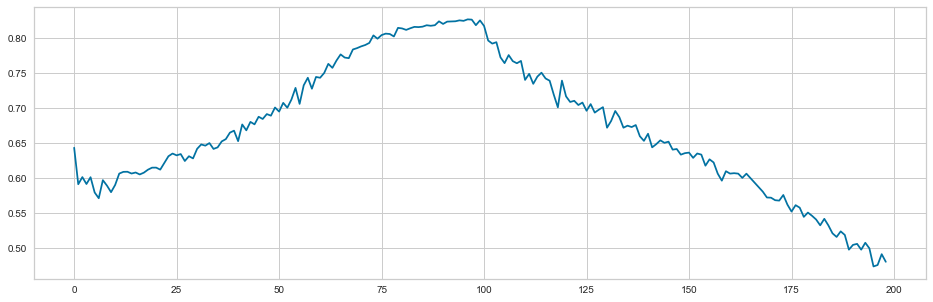

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
 
# create data
values=cluster_performance[['Silhouette']]

newdims = (16, 5)
fig, ax = plt.subplots(figsize=newdims)

# use the plot function
plt.plot(values)

The highest silhouette coefficient - 0.827 - is found with 98 clusters, but a standard deviation of 5.226 indicates high variance.  
Below we look at the ten highest silhouette coefficient scores to include accuracy and standard deviation.  

With 92 clusters, we can achieve 85.814% accuracy with a much tighter variance of on 2.641. This looks to be the optimal number of k-means clusters.

In [18]:
best_silhouette = cluster_performance.sort_values(by='Silhouette',ascending=False)
best_silhouette.head(15).style.background_gradient(cmap='GnBu_r', subset='SD').background_gradient(
    cmap='GnBu', subset='Accuracy').hide_index()

Clusters,Accuracy,SD,Silhouette
98,87.2093,5.22609,0.827314
99,85.5814,5.07382,0.826925
96,86.2791,4.088,0.825872
101,86.0465,5.40416,0.825824
97,86.7442,4.53935,0.825172
95,86.7442,5.60557,0.824556
91,85.5814,3.41789,0.824481
94,84.6512,5.52295,0.824296
93,84.186,5.5814,0.824077
92,85.814,2.64135,0.820748


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

Below we visualize a scatter plot, labelled using our clusters.  
Interpreting this with 92 different labels may be approaching useless, but...there it is!

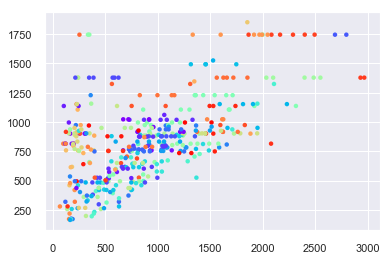

In [20]:
labels = KMeans(n_clusters=92, init='k-means++',n_init=10,random_state=1).fit_predict(X)
# plt.scatter(X[:, 0], X[:, 1], c=labels,s=50, cmap='viridis');
plt.scatter(X[:, 0], X[:, 1]+np.random.random(X[:, 1].shape)/2, c=newfeature, cmap=plt.cm.rainbow, s=20, linewidths=0)

Next, we'll look at Agglomerative Clustering.

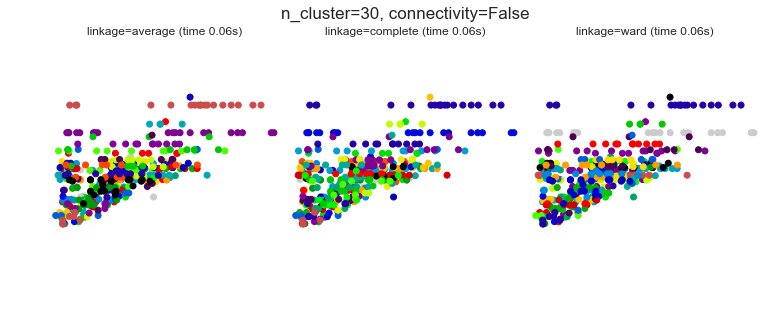

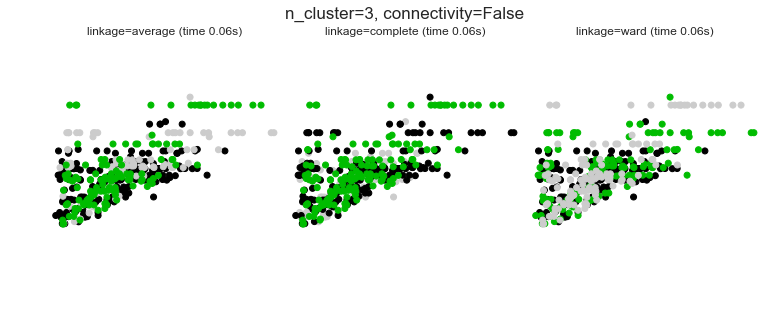

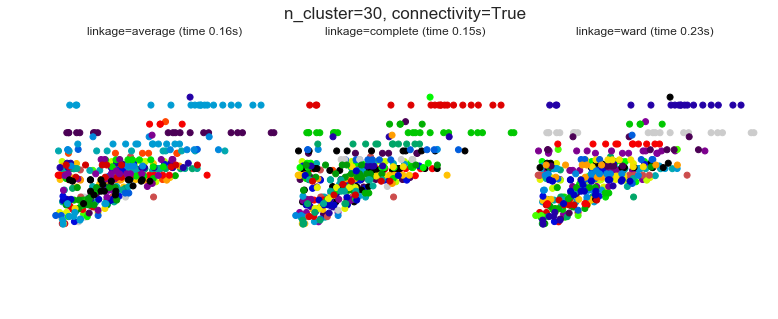

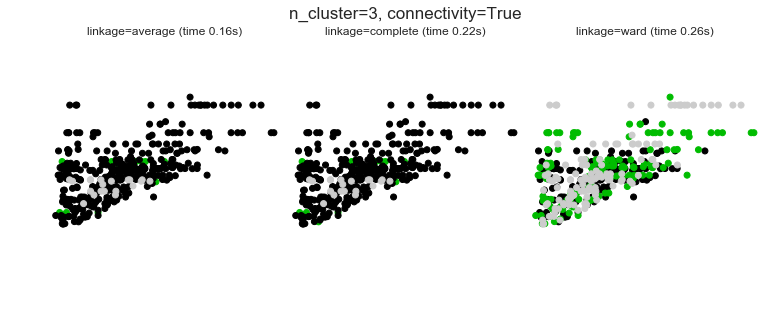

In [21]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Generate sample data
n_samples = 1500
np.random.seed(0)
#t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = X_class
y = Y_class

# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
knn_graph = kneighbors_graph(X, 30, include_self=False)

for connectivity in (None, knn_graph):
    for n_clusters in (30, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(('average', 'complete', 'ward')):
            plt.subplot(1, 3, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters)
            t0 = time.time()
            model.fit(X)
            elapsed_time = time.time() - t0
            plt.scatter(X[:, 0], X[:, 1], c=model.labels_,
                        cmap=plt.cm.nipy_spectral)
            plt.title('linkage=%s (time %.2fs)' % (linkage, elapsed_time),
                      fontdict=dict(verticalalignment='top'))
            plt.axis('equal')
            plt.axis('off')

            plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                                left=0, right=1)
            plt.suptitle('n_cluster=%i, connectivity=%r' %
                         (n_clusters, connectivity is not None), size=17)


plt.show()

Thirdly, we'll look at HDBSCAN, a hierarchical implementation of DBSCAN for non-spherical data.  
See https://towardsdatascience.com/lightning-talk-clustering-with-hdbscan-d47b83d1b03a,  
https://towardsdatascience.com/lightning-talk-clustering-with-hdbscan-d47b83d1b03a

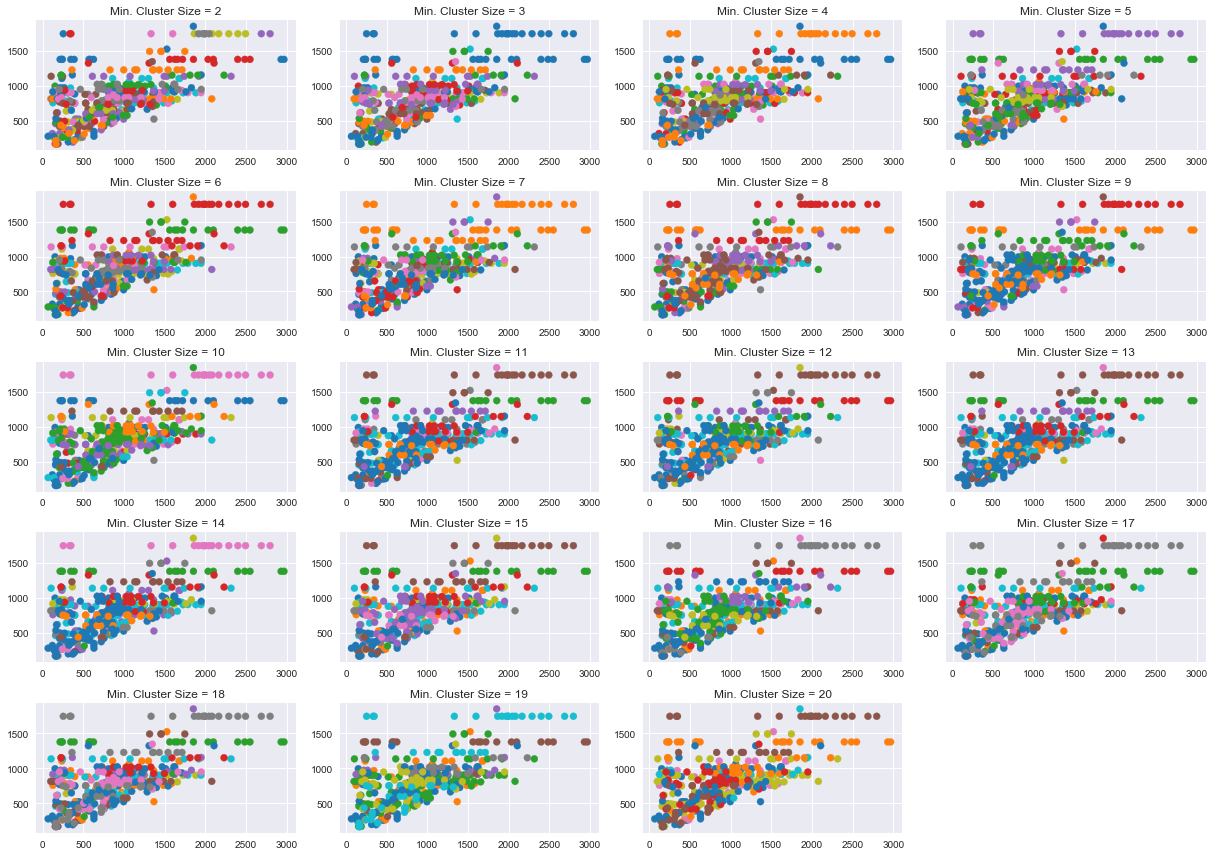

In [62]:
import hdbscan

plt.style.use('seaborn')
cmap = 'tab10'

clust_count = np.linspace(1, 20, num=20, dtype='int')

clust_number = 2
plot_number = 1
plt.figure (figsize=(17,12))
while clust_number < 21:
    hdb = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40,
    metric='euclidean', min_cluster_size=clust_number, min_samples=None, p=None)
    hdb_pred = hdb.fit(hs_2017)
    plt.subplot(5, 4, plot_number, title = 'Min. Cluster Size = {}'.format(clust_number))
    plt.scatter(hs_2017.values[:,0], hs_2017.values[:,1], c=hdb_pred.labels_, cmap=cmap)
    plot_number += 1
    clust_number += 1

plt.tight_layout()